In [1]:
from __future__ import print_function
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from ipywidgets import interact, interactive, fixed, interact_manual
import scipy
import os
from scipy.interpolate import RegularGridInterpolator as rgi
from tqdm import tqdm

In [2]:
%load_ext line_profiler

## Initialize Stuff

In [3]:
def genSeeds(size,ntypes,nseeds=None,poss=None):
    if not nseeds:
        nseeds=ntypes
    
    Colors = np.zeros(size,dtype='int')
    
    if not poss:
        poss = np.random.randint(0,Colors.shape,(nseeds,2))

    for i,pos in enumerate(poss):
        Colors[pos[0],pos[1]] = i%ntypes +1
    return Colors

In [4]:
meshsize = (150,150)

x= np.linspace(0,1,meshsize[0],endpoint=True)
y = np.linspace(0,1,meshsize[1],endpoint=True)
X,Y = np.meshgrid(x,y,indexing='ij')

In [5]:
nseeds = 60

velocities = np.ones(nseeds+1)
velocities[0] = 0

velocities = velocities

In [6]:
Colors = np.zeros(X.shape,dtype='int')

poss = np.random.randint(0,meshsize,(nseeds,2))

for i,pos in enumerate(poss):
    Colors[pos[0],pos[1]] = i+1

## Monte Carlo - Naive

__Major Takeaways__
- Velocity is one grid spacing per cell if $v_{max}=1$
- Any $v_{max}<1$ gives a more `random' distribution
    - This means that we should try our best to keep a mesh size much smaller than the actual velocity since we want to cover multiple steps
    - We should use normalized velocities to give the least `random' result
- An $\epsilon = 0.2$ gives the most `circular' grains (for calibration, by area)
- The mesh can have different dimensions but for now, needs to have the **same step size**
- The x-y growth has $p=1$ (is certain) for $v_{max} = 1$ which means that we can `control' the randomness
- Directional growth velocity is hard to implement which presents a challenge
- Directional growth seems to have a linear correlation with the scaled velocity set but it's different for the diagonal direction (could be related to the epsilon value not being right)

In [7]:
def f(x):
    return 2*(1-x)**4 + (1 - (1-x)**4) - np.sqrt(2)

eps = scipy.optimize.fsolve(f,0.2)[0]

In [8]:
problist = np.array([[eps,1,eps],[1,1,1],[eps,1,eps]])
# problist = np.array([[eps,1,eps],[0,1,0],[eps,1,eps]])

In [9]:
def MCStep(Colors,velocities=velocities,problist=problist,periodic=False,vsame=True,vscalefield = 1):
    
    Colors2 = Colors.copy()

    if not periodic:
        Colors2 = np.pad(Colors2,1,mode='constant')
        vscalefield = np.pad(vscalefield,1,mode='constant')
    size = Colors2.shape

    # Checking which ones are to be changed (If they have a recrystalized neighbor and are deformed)
    kernel = np.ones((3,3))
    kernel[1,1] = -100

    IfNeighbor = convolve2d(Colors2!=0,kernel,mode='same',boundary='wrap')
    IfNeighbor=IfNeighbor>0
    
    # Making a neighborhood and velocity array for each pixel
    Neighborhood = np.zeros((9,size[0],size[1]),dtype='int')
    gvel = np.zeros(Neighborhood.shape)
    
    n = np.array([-1,0,1])
    nX,nY = np.meshgrid(n,n)
    nX = nX.reshape(-1)
    nY = nY.reshape(-1)
    
    for i in range(9):
        neigh = np.roll(Colors2,[nX[i],nY[i]],[0,1])
        Neighborhood[i] = neigh
        if vsame:
            gvel[i] = neigh>0
        if not vsame:
            gvel[i] = velocities[neigh]
    
    probweights = problist.reshape(-1)[:,np.newaxis,np.newaxis]*gvel
    
    # Selecting a random index from the nearby pixels according to the probability
    cumsum = np.cumsum(probweights,axis=0)
    cumsum = cumsum-np.random.random(size)*cumsum[-1]
    selectidx = np.argmax(cumsum>0,axis=0)

    
    idx = np.indices(size).reshape(2,-1).T
    selected = Neighborhood[selectidx.ravel(),idx[:,0],idx[:,1]].reshape(size)
    
    # Select all pixels with that identity
    IfSelected = Neighborhood==selected[np.newaxis,:,:]
    # Take the pixel with the maximum probability corresponding to that point
    probs = np.max(probweights*IfSelected,axis=0) * vscalefield
    
    # Doing a rng check for the selected pixels 
    ifchange = np.random.random(size)<probs
    
    # An array with the new selected pixels
    selected = Neighborhood[selectidx.ravel(),idx[:,0],idx[:,1]].reshape(size)
    
    # Setting the pixels to the new one where both the RnG and the neighborhood criteria is satisfied
    Colors2[np.where(ifchange & IfNeighbor)] = selected[np.where(ifchange & IfNeighbor)]

    if not periodic:
        Colors2 = Colors2[1:-1,1:-1]
    return Colors2

In [10]:
def runRecryst(Colors,velocities=velocities,vscalefield = 1,ByFraction=True,Ffin = 1,steps = 100,periodic=False,vsame=True):
    imagelist = []
    imagelist.append(Colors.copy())
    size = Colors.shape
    Colorstemp = Colors.copy()
    F = np.count_nonzero(Colors)/(np.cumprod(size)[-1])
    if ByFraction:
        while F<Ffin:
        # for i in range(100):
            Colors2 = MCStep(Colorstemp,vscalefield=vscalefield,periodic=periodic,velocities=velocities,vsame=vsame)
            imagelist.append(Colors2.copy())
            F = np.count_nonzero(Colors2)/(np.cumprod(size)[-1])
            Colorstemp = Colors2
    else:
        for i in range(steps):
            Colors2 = MCStep(Colorstemp,vscalefield=vscalefield,periodic=periodic,velocities=velocities,vsame=vsame)
            imagelist.append(Colors2.copy())
            Colorstemp = Colors2
    imagelist = np.array(imagelist,dtype='int')
    return imagelist

### Circle Test

In [253]:
meshsize = np.array((100,100))
Colors = genSeeds(meshsize,1)

In [254]:
# vmuls = np.logspace(0,-1,10)
vmuls = np.linspace(0.05,1,20)
numb = 10

In [255]:
dist = np.sqrt(int(meshsize[1])**2 + int(meshsize[0])**2)
idealsteps = dist/vmuls
# idealsteps = int(meshsize[0])/vmuls

In [229]:
steps = np.zeros(len(vmuls))
stddev = np.zeros(len(vmuls))
for j,vmul in enumerate(tqdm(vmuls)):
    lens = np.zeros(numb)
    p = vmul
    for i in range(numb):
        Colors[:,:] = 0
        Colors[0,0] = 1
        l = 0
        C = True
        while C:
            Colors = MCStep(Colors,vscalefield=p)
            l+=1
            if Colors[-1,-1]!=0:
            # if Colors[0,0]!=0 or Colors[0,-1]!=0 or Colors[-1,0]!=0 or Colors[-1,-1]!=0:
            # if Colors[0,0]!=0:
                C=False   
        lens[i] = l
    stddev[j] = np.std(lens)
    steps[j] = lens.mean()
vsim = dist/steps

100%|██████████| 20/20 [01:27<00:00,  4.37s/it]


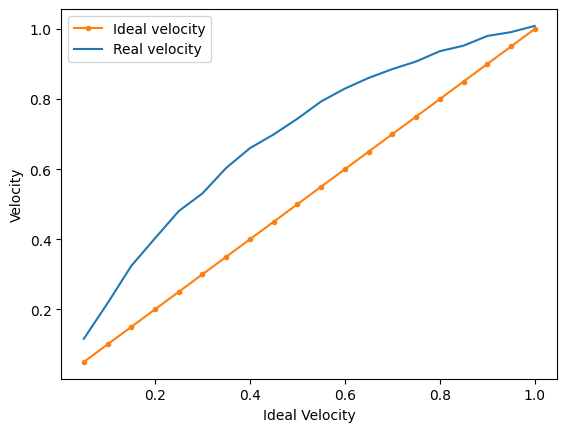

In [230]:
plt.errorbar(vmuls,dist/steps,ls='-',yerr = None,xerr=None,label='Real velocity')
plt.plot(vmuls,dist/idealsteps,'.-',label='Ideal velocity')
plt.ylabel('Velocity')
plt.xlabel('Ideal Velocity')
plt.legend()

[ 0.66653975 -2.01740165]


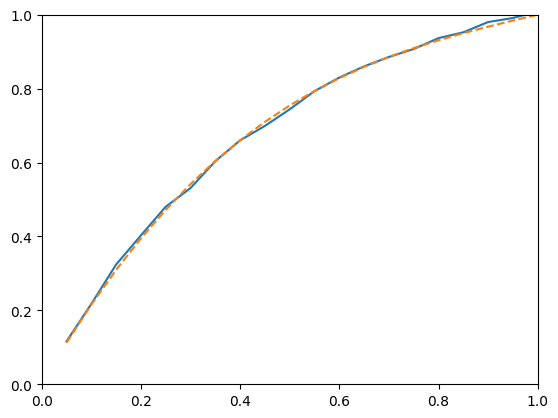

In [250]:
def fitfunc(x,m1,m2):
    return m1*x**3 + m2*x**2 + (1-m1-m2)*x

params = scipy.optimize.curve_fit(fitfunc,vmuls,vsim)[0]
plt.plot(vmuls,vsim)
plt.plot(vmuls,fitfunc(vmuls,*params),'--')
plt.xlim([0,1])
plt.ylim([0,1])
print(params)

In [256]:
def getP(v):
    return scipy.optimize.fsolve(lambda x :fitfunc(x,*params)-v,v)[0]

In [260]:
steps = np.zeros(len(vmuls))
stddev = np.zeros(len(vmuls))
for j,vmul in enumerate(tqdm(vmuls)):
    lens = np.zeros(numb)
    p = getP(vmul)
    for i in range(numb):
        Colors[:,:] = 0
        Colors[0,0] = 1
        l = 0
        C = True
        while C:
            Colors = MCStep(Colors,vscalefield=p)
            l+=1
            if Colors[-1,-1]!=0:
            # if Colors[0,0]!=0 or Colors[0,-1]!=0 or Colors[-1,0]!=0 or Colors[-1,-1]!=0:
            # if Colors[0,0]!=0:
                C=False   
        lens[i] = l
    stddev[j] = np.std(lens)
    steps[j] = lens.mean()
vsim = dist/steps

100%|██████████| 20/20 [02:36<00:00,  7.82s/it]


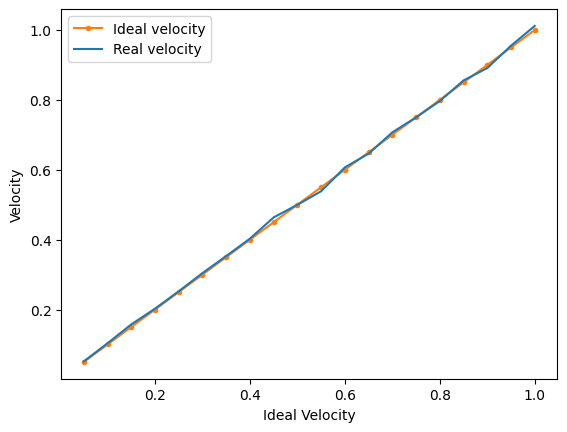

In [261]:
plt.errorbar(vmuls,dist/steps,ls='-',yerr = None,xerr=None,label='Real velocity')
plt.plot(vmuls,dist/idealsteps,'.-',label='Ideal velocity')
plt.ylabel('Velocity')
plt.xlabel('Ideal Velocity')
plt.legend()

### Diagonal Test

In [306]:
meshsize = np.array((200,200))
Colors = genSeeds(meshsize,1)

In [307]:
vmuls = np.logspace(0,-1,5)
vmuls = np.linspace(0.1,1,10)
numb = 5

In [308]:
steps = np.zeros(len(vmuls))
for j,vmul in enumerate(tqdm(vmuls)):
    lens = np.zeros(numb)
    for i in range(numb):
        Colors[:,:] = 0
        Colors[0,0] = 1
        l = 0
        C = True
        while C:
            Colors = MCStep(Colors,vscalefield=vmul)
            l+=1
            if Colors[int(meshsize[0]/2),int(meshsize[1]/2)]:
            # if Colors[0,0]!=0:
                C=False   
        lens[i] = l
    steps[j] = lens.mean()

100%|██████████| 10/10 [01:57<00:00, 11.77s/it]


In [305]:
@interact(x=(0,len(imagelist)-1))
def plot(x):
    plt.imshow(imagelist[x])
    plt.colorbar()

interactive(children=(IntSlider(value=136, description='x', max=273), Output()), _dom_classes=('widget-interac…

In [309]:
idealsteps = np.sqrt(int(meshsize[1]/2)**2 + int(meshsize[0]/2)**2) /vmuls

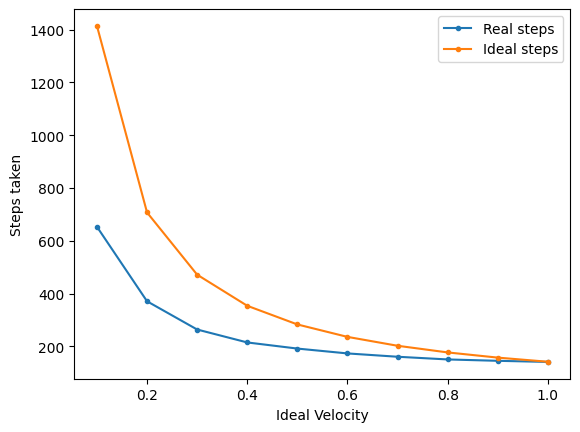

In [310]:
plt.plot(vmuls,steps,'.-',label='Real steps')
plt.plot(vmuls,idealsteps,'.-',label='Ideal steps')
plt.ylabel('Steps taken')
plt.xlabel('Ideal Velocity')
plt.legend()

In [302]:
steps[-1],int(meshsize[0]/2)*np.sqrt(2)

(278.2, 282.842712474619)

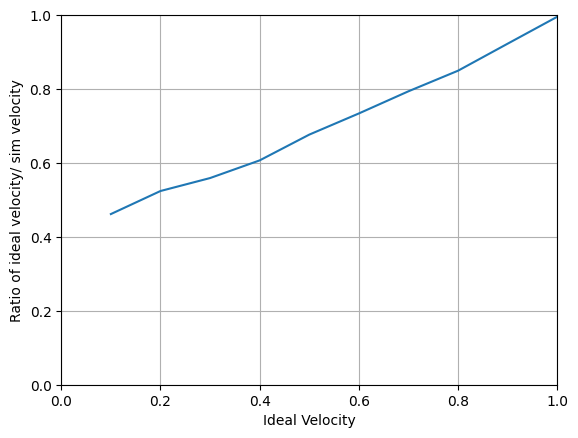

In [311]:
plt.plot(vmuls,steps/idealsteps)
plt.ylabel('Ratio of ideal velocity/ sim velocity')
plt.xlabel('Ideal Velocity')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()

In [304]:
params = np.polyfit(vmuls,steps/idealsteps,deg=1)
params

array([0.59402112, 0.37598282])

### Line Test

In [319]:
meshsize = np.array((100,100))
Colors = genSeeds(meshsize,1)

In [320]:
Colors[:,:] = 0
Colors[:,0] = 1

In [321]:
vmuls = np.logspace(0,-1,20)
vmuls = np.linspace(0.1,1,20)
numb = 5

In [324]:
dist = int(meshsize[1])
idealsteps = dist/vmuls
vsim = dist/steps

In [323]:
periodic = False
steps = np.zeros(len(vmuls))
for j,vmul in enumerate(tqdm(vmuls, desc=" outer", position=0)):
    lens = np.zeros(numb)
    for i in tqdm(range(numb), desc=" inner loop", position=1, leave=False):
        p = getP(vmul)
        imagelist = runRecryst(Colors,vscalefield=p)
        lens[i] = len(imagelist)-1
    steps[j] = lens.mean()
vsim = dist/steps

 outer: 100%|██████████| 20/20 [01:17<00:00,  3.88s/it]


In [316]:
@interact(x=(0,len(imagelist)-1))
def plot(x):
    plt.imshow(imagelist[x])
    plt.colorbar()

interactive(children=(IntSlider(value=149, description='x', max=299), Output()), _dom_classes=('widget-interac…

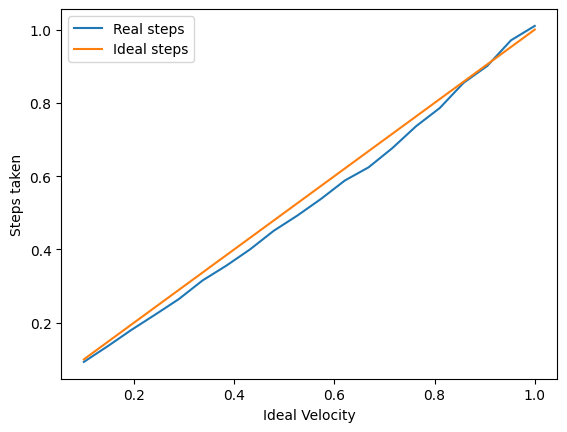

In [325]:
plt.plot(vmuls,vsim,label='Real steps')
plt.plot(vmuls,dist/idealsteps,label='Ideal steps')
plt.ylabel('Steps taken')
plt.xlabel('Ideal Velocity')
plt.legend()

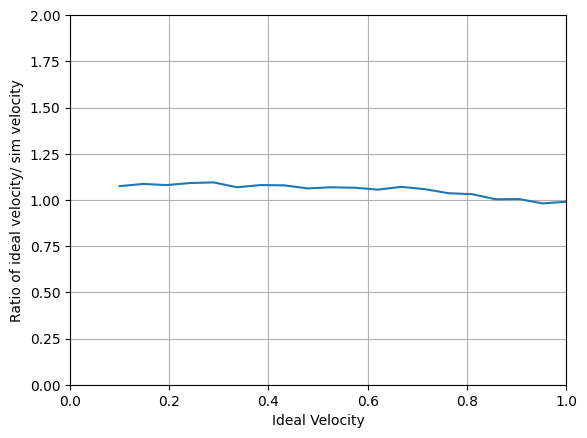

In [326]:
plt.plot(vmuls,steps/idealsteps)
plt.ylabel('Ratio of ideal velocity/ sim velocity')
plt.xlabel('Ideal Velocity')
plt.xlim(0,1)
plt.ylim(0,2)
plt.grid()

### $R^2$ Norm test

In [27]:
Colors = np.zeros(X.shape,dtype='int')

poss = np.random.randint(0,meshsize,(nseeds,2))

for i,pos in enumerate(poss):
    Colors[pos[0],pos[1]] = i+1

In [28]:
# R2 norm coloring, with periodic boundary conditions
R2 = np.zeros(Colors.shape)
for i in range(R2.shape[0]):
    for j in range(R2.shape[1]):
        x = poss[:,0]-i
        y = poss[:,1]-j
        if periodic:
            x = np.minimum(x,Colors.shape[0]-x)
            y = np.minimum(y,Colors.shape[1]-y)
        R2[i,j] = np.argmin(x**2+y**2)+1

In [29]:
numb = 20
last_image = np.zeros((numb,Colors.shape[0],Colors.shape[1]))
for i in range(numb):
    imagelist = runRecryst(Colors,periodic=periodic,velocities=velocities)
    last_image[i] = imagelist[-1]

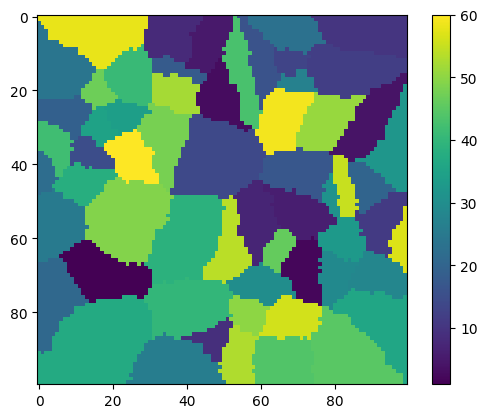

In [30]:
plt.imshow(last_image[-1])
plt.colorbar()

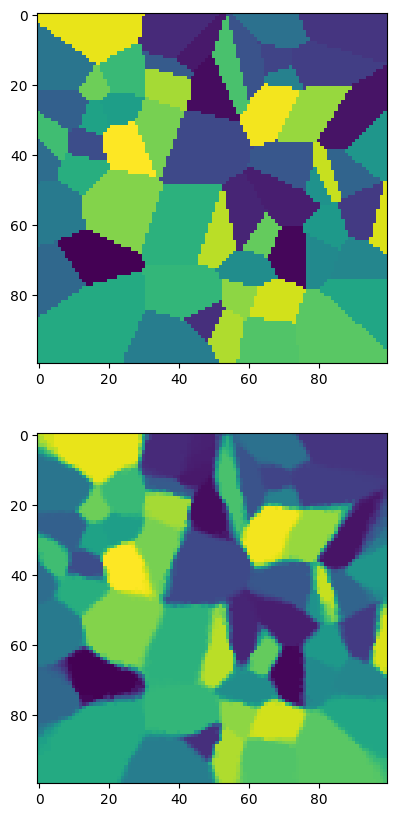

In [31]:
fig,axs = plt.subplots(2)
fig.set_figwidth(10)
fig.set_figheight(10)
axs[0].imshow(R2)
axs[1].imshow(np.mean(last_image,axis = 0))
# axs[1].imshow(last_image[-1])

## Different growth velocity test

In [211]:
Colors = np.zeros(X.shape,dtype='int')

poss = np.random.randint(0,meshsize,(nseeds,2))

for i,pos in enumerate(poss):
    Colors[pos[0],pos[1]] = i+1

In [212]:
vscalefield = np.ones(Colors.shape)
vscalefield[int(vscalefield.shape[0]/2):,:] = 0.2

In [213]:
imagelist = runRecryst(Colors,vscalefield=vscalefield)

In [214]:
@interact(x=(0,len(imagelist)-1))
def plot(x):
    plt.imshow(imagelist[x])

interactive(children=(IntSlider(value=43, description='x', max=87), Output()), _dom_classes=('widget-interact'…

## Mapping the velocities to temperatures and comparing with Avrami plot

In [2]:
def GrowthT(T):
    N0 = 17.4E6
    v0 = 2.1E4
    UbyR = 755
    Kg = 534858
    T0m = 467
    phi = 0.155
    Tg = 266
    rho = 900
    cp = 2.14E3
    kp = 0.193
    return v0*np.exp(-(UbyR)/(T-Tg+30))*np.exp(-Kg/(T*(T0m-T)))

def Nucleation(T):
    N0 = 17.4E6
    phi = 0.155
    v0 = 2.1E4
    UbyR = 755
    Kg = 534858
    T0m = 467
    Tg = 266
    rho = 900
    cp = 2.14E3
    kp = 0.193
    return 1.458*(N0*np.exp(phi*(T0m-T)))**(2/3)

In [3]:
def numAlpha(imagelist):
    alphas = np.zeros(len(imagelist))
    alphas = np.count_nonzero(imagelist,axis=tuple(range(1,len(imagelist.shape))))/np.product([*imagelist.shape[1:]])
    return alphas

def analAlpha(T):
    t = np.linspace(0,6,600)
    alphas = 1-np.exp(-np.pi*Nucleation(T)*(GrowthT(T)**2)*(t**2))
    return t,alphas

In [4]:
area = 200E-6**2
Ts = [340,355,360,365,370,375]
# Ts = [360,370]
Ts = np.array(Ts)

In [8]:
[int(Nucleation(T)*area) for T in Ts]

[1959, 415, 248, 148, 88, 52]

In [205]:
domainsize = (600,600)
dx = 2E-4/domainsize[0]
numAlphas = []
analAlphas = []
for i,T in enumerate(tqdm(Ts)):
    nseeds = int(Nucleation(T)*area)
    Colors = genSeeds(domainsize,ntypes=nseeds)
    imagelist = runRecryst(Colors)
    numAlphas.append(numAlpha(imagelist))
    t,analaplh = analAlpha(T)
    analAlphas.append((t,analaplh))

100%|██████████| 6/6 [00:42<00:00,  7.11s/it]


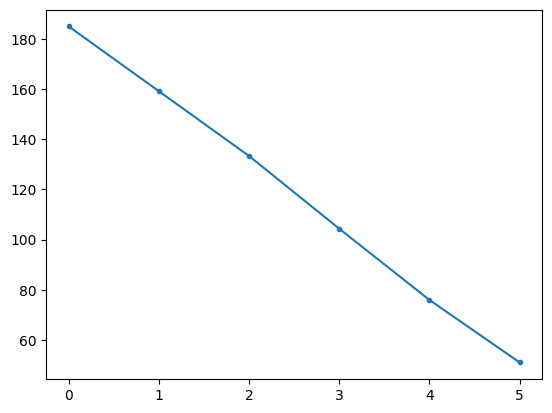

In [206]:
plt.plot(GrowthT(Ts)/dx,'.-')
timescale = GrowthT(Ts)/dx

(0.0, 1.5)

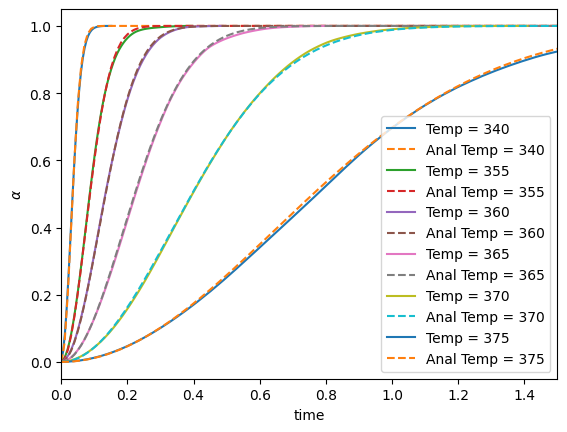

In [208]:
for i in range(len(Ts)):
    plt.plot(np.arange(len(numAlphas[i]))/timescale[i],numAlphas[i], label = 'Temp = {}'.format(Ts[i]))
    plt.plot(analAlphas[i][0], analAlphas[i][1],'--',label='Anal Temp = {}'.format(Ts[i]))
plt.legend()
plt.xlabel('time')
plt.ylabel('$\\alpha$')
plt.xlim(0,1.5)

In [265]:
N = Nucleation(Ts)
G = GrowthT(Ts)
scaledG = G/np.max(G)
scaledG

array([1.        , 0.86038217, 0.72065845, 0.5639958 , 0.41036476,
       0.27569422])

In [276]:
domainsize = (600,600)
dx = 2E-4/domainsize[0]
numAlphas = []
analAlphas = []
for i,T in enumerate(tqdm(Ts)):
    nseeds = int(Nucleation(T)*area)
    Colors = genSeeds(domainsize,ntypes=nseeds)
    p = getP(scaledG[i])
    imagelist = runRecryst(Colors,vscalefield=p,periodic=True)
    numAlphas.append(numAlpha(imagelist))
    t,analaplh = analAlpha(T)
    analAlphas.append((t,analaplh))

100%|██████████| 6/6 [01:25<00:00, 14.32s/it]


Text(0.5, 0, '$t$')

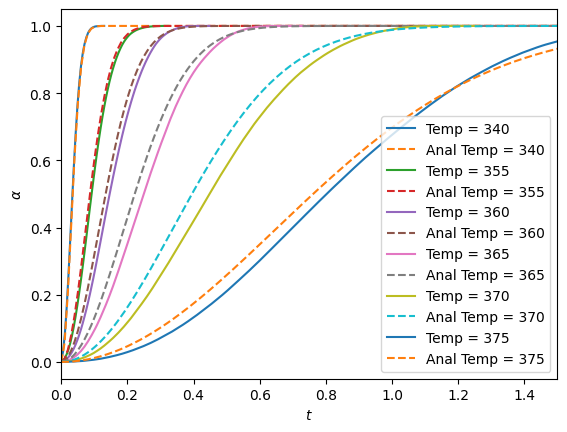

In [277]:
for i in range(len(Ts)):
    
    plt.plot(np.arange(0,len(numAlphas[i])) * dx / np.max(G)
             ,numAlphas[i],label = 'Temp = {}'.format(Ts[i]))
    
    plt.plot(analAlphas[i][0]
             ,analAlphas[i][1],'--',label='Anal Temp = {}'.format(Ts[i]))
plt.legend()
plt.xlim(0,1.5)
plt.ylabel('$\\alpha$')
plt.xlabel('$t$')

## Growth Fields

In [327]:
domainsize = (500,500)
ntypes = 40
Colors = genSeeds(domainsize,ntypes)

In [328]:
Colors[:,:] = 0
Colors[:,int(domainsize[0]/2)] = 1

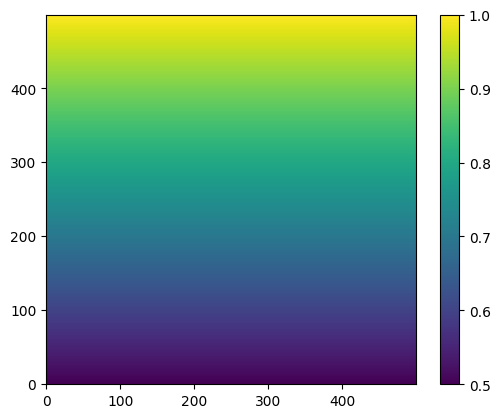

In [329]:
# Initialize Scaling Field

vscalefield = np.ones(domainsize)
gradient = np.linspace(0.5,1,domainsize[0])


vscalefield = vscalefield*gradient[:,np.newaxis]
p = np.array([[getP(vscalefield[i,j]) for j in range(vscalefield.shape[1])] for i in range(vscalefield.shape[0])])
plt.imshow(vscalefield,origin='lower')
plt.colorbar()

In [334]:
imagelist = runRecryst(Colors,vscalefield=p)

In [335]:
@interact(x=(0,len(imagelist)-1))
def plot(x):
    plt.imshow(imagelist[x],origin='lower')

interactive(children=(IntSlider(value=243, description='x', max=486), Output()), _dom_classes=('widget-interac…

# Real Data Test

- Switched from 2-d to 3-d interpolation (in time) because the initial data was too far apart in time
- Having problems with interpolation and then subsequent differentiation, a lot of noise during interpolation
- Can only do linear interpolation on the 3d (time and 2 axes) grid, cubic and spline take up too much memory
- Maybe using np.isclose() is better than array==0 to check for zeros

### Initializing preprocessing

In [116]:
def goodplot(plotlist):
    if type(plotlist)!=list:
        plt.figure(figsize=[18,3])
        plt.imshow(plotlist.T,origin='lower')
        plt.colorbar()
        return
    n = len(plotlist)
    fig,axs = plt.subplots(n)
    fig.set_figwidth(18)
    fig.set_figheight(n*2)
    for i,field in enumerate(plotlist):
        a=axs[i].imshow(field.T,origin='lower')
        fig.colorbar(a)

In [43]:
fields= [_[:-4] for _ in os.listdir() if '.npy' in _]
for _ in fields:
    exec(_ + " = np.load( '"+_+".npy')")
print(fields)

['time', 'tn', 'MeshZ', 'MeshY', 'MeshX', 'R', 'f', 'fs']


In [44]:
dx = MeshX[1,0,0] - MeshX[0,0,0]
dy = MeshY[0,1,0] - MeshY[0,0,0]
dz = MeshZ[0,0,1] - MeshZ[0,0,0]

### Choosing the X-Z plane

In [105]:
N_div = 10
time_div = 2
L = min(dx,dz)/N_div
x = np.arange(MeshX[0,0,0],MeshX[-1,0,0],L)
z = np.arange(MeshZ[0,0,0],MeshZ[0,0,-1],L)
t = np.linspace(time[0],time[-1], time_div*len(time) ,endpoint=True)

In [62]:
yslice = int(MeshX.shape[1]/2)

In [63]:
T,X,Z = np.meshgrid(t,x,z,indexing='ij')

### Processing fields

In [65]:
# Interpolating linearly

TN = scipy.interpolate.interpn((time,MeshX[:,0,0],MeshZ[0,0,:]),tn[:,:,yslice,:],(T,X,Z),method='linear')
FS = scipy.interpolate.interpn((time,MeshX[:,0,0],MeshZ[0,0,:]),fs[:,:,yslice,:],(T,X,Z),method='linear')
FN = scipy.interpolate.interpn((time,MeshX[:,0,0],MeshZ[0,0,:]),f[:,:,yslice,:],(T,X,Z),method='linear')

In [66]:
tsol = 1600
tliq = 1733

In [67]:
# Calculate R

Tdot = np.gradient(TN,t,axis = 0)
gradX = np.gradient(TN,x,axis=1)
gradZ = np.gradient(TN,z,axis=2)
gradX[np.isclose(FN,0)] = 0
gradZ[np.isclose(FN,0)] = 0

In [132]:
grad = np.sqrt(gradX**2+gradZ**2)
RN = np.zeros(TN.shape)
RN[np.invert(np.isclose(grad,0))] = -Tdot[np.invert(np.isclose(grad,0))]/grad[np.invert(np.isclose(grad,0))]
RN[RN<0] = 0      # Growth Velocity positive

### Initializing Mesh

In [72]:
ntypes = 48
nseeds = 4000


velocities = np.ones(ntypes+1)
velocities[0] = 0

velocities = velocities

In [76]:
Colors = np.zeros(X.shape[1:],dtype='int')

poss = np.random.randint(0,Colors.shape,(nseeds,2))

for i,pos in enumerate(poss):
    Colors[pos[0],pos[1]] = i%ntypes +1

In [77]:
periodic = False

R2 = np.zeros(Colors.shape,dtype='int')

for i in range(R2.shape[0]):
    for j in range(R2.shape[1]):
        x = poss[:,0]-i
        y = poss[:,1]-j
        if periodic:
            x = np.minimum(x,Colors.shape[0]-x)
            y = np.minimum(y,Colors.shape[1]-y)
        R2[i,j] = np.argmin(x**2+y**2)%ntypes+1

In [185]:
Colors = R2
Colors[np.invert(np.isclose(FS[0],1))] = 0

In [107]:
# Colorscopy = Colors.copy()
Colors = Colorscopy.copy()

### Filtering the growth rate

__Problems__
- Need the growth rate to only exist in the melt
    - Hopefully, Fs and F can give us the required information 
- Need the growth rate to represent growth from the last step till the next step
    - Could set the growth at the current step to be 0 if at the next step, $f_s\neq 1$
        - Doing this makes interpolation in time seem meaningless as the growth rate every other step is 0
- There exist `islands' where there is growth but separated from the actual growing part
    - If lower thing can be followed, this can be solved
- Need to define when to end the MC steps
    - Could do it when a new step doesn't add more (only if the growth part has $v_{max}=1$)

In [156]:
growth = RN.copy()

In [176]:
growth[np.invert(np.isclose(FN,1))] = 0   # Only growth where material present
growth[np.isclose(FS,1)] = 0    # No growth in solid

In [178]:
for i in range(len(growth)-1):
    A = growth[i]
    A[np.invert(np.isclose(FS[i+1],1))] = 0

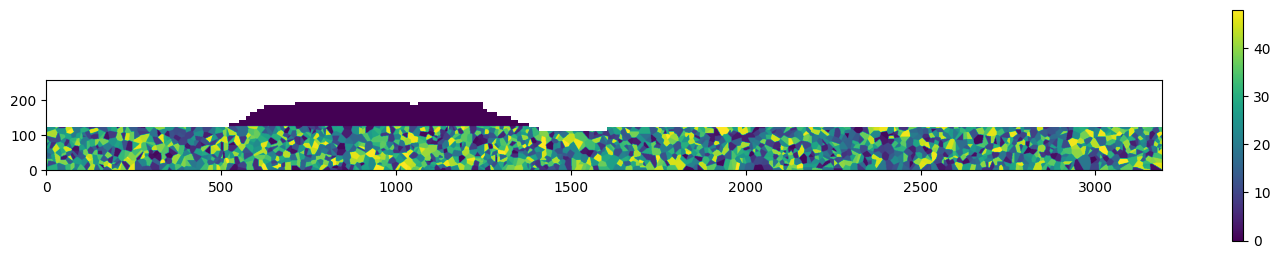

In [191]:
goodplot(np.ma.masked_array(Colors,np.invert(np.isclose(FS[22],1)) ,fill_value=0))

In [190]:
1+np.nan

nan

In [215]:
@interact(st=(0,len(t)-1))
def a(st):
    goodplot([growth[st],
              np.nansum(growth[:st+1],axis=0) -0.01*(Colors>0),
              FN[st],
              FS[st],
              TN[st]])

interactive(children=(IntSlider(value=21, description='st', max=43), Output()), _dom_classes=('widget-interact…

### Stepping through with MC steps

In [433]:
imagelist = []

In [475]:
st = 3

In [ ]:
growthfield = RN[st].copy()
growthfield[Colors!=0] = 0
growthfield[RN[st+1]!=0] = 0

Colors[FS[st]<0.99] = 0
n = np.count_nonzero(growthfield)
if np.count_nonzero(growthfield):
    F = np.count_nonzero(Colors[growthfield>0])/n
else:
    F = 1
# while F<1:
for i in range(100):
    if np.max(growthfield):
        scalefield = growthfield/np.max(growthfield)
        
    Colors2 = MCStep(Colors,periodic=False,vsame=True,vscalefield=scalefield)
    Colors = Colors2
    imagelist.append(Colors.copy())
    F = np.count_nonzero(Colors[growthfield>0])/n
    print(F)

In [435]:
np.count_nonzero(RN[8])

31874

In [480]:
@interact(x=(0,len(imagelist)-1))
def plot(x):
    plt.imshow(imagelist[x][500:1000,100:170].T ,origin='lower')
    plt.colorbar()

interactive(children=(IntSlider(value=31, description='x', max=62), Output()), _dom_classes=('widget-interact'…